In [35]:
import cv2 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from skimage import color
import pandas as pd
import glob
from numpy.linalg import norm
from shapely import geometry
from SiftFunctions import *
from PIL import Image
import random
import os
from collections import Counter
%matplotlib inline

In [ ]:
"""
This notebook (WIP!!!) evaluates whether an image consists of multiple image, based on the SIFT features of the original:

_____________________________
|                |          |
| original image |          |
|                |          |
_____________________________

A rectangle is drawn around the SIFT keypoints. Then, using simple rules, it is determined if the rectangle is roughly half the size
of the image. Then it is located and the other half is selected. 

"""

In [2]:
img1 = cv2.imread('F:/react-data/iconic/image-analysis/test_results/Monk/original/original.jpg')

In [27]:
d = []
for img_fn in random.sample(glob.glob('F:/react-data/iconic/image-analysis/test_results/Monk/preproc_2/*'),2500):
    img2 = cv2.imread(img_fn)
    height, width = img2.shape[:2]
    
    try:
        # Get Keypoint Matches
        src, dst = sifter(img1,img2)
    
        # Get Rectangle Coordinates for Target Image
        min_y = min(dst, key = lambda t: t[1])[1]
        if min_y < 0:
            min_y = 0
        max_y = max(dst, key = lambda t: t[1])[1]
        min_x = min(dst, key = lambda t: t[0])[0]
        if min_x < 0:
            min_x = 0
        max_x = max(dst, key = lambda t: t[0])[0]

        # Get Area Dimensions
        width_area = max_x - min_x
        height_area = max_y - min_y
        
        d.append([os.path.split(img_fn)[-1],round(min_x),round(max_y),round(max_x),round(min_y),width,height,round(width_area),round(height_area)])
    except Exception as e:
        print(e)
        continue

Not enough matches are found - 9/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 6/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 5/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 0/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 6/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 2/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 9/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 2/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 10/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 9/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 8/10
local variable 'src_pts' referenced before assignment
Not enoug

Not enough matches are found - 2/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 2/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 8/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 7/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 10/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 9/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 1/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 6/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 9/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 10/10
local variable 'src_pts' referenced before assignment
Not enough matches are found - 7/10
local variable 'src_pts' referenced before assignment
Not enou

In [28]:
d = pd.DataFrame(d,columns = "fn min_x max_y max_x min_y width_image height_image width_area height_area".split(' '))

In [29]:
def half_image_test(min_x,max_x,min_y,max_y,perc_height,perc_width,image_width,image_height):
    top_line_perc = max_y / image_height
    bottom_line_perc = min_y / image_height
    right_line_perc = max_x / image_width
    left_line_perc = min_x / image_width
    
    if perc_height > 0.4 and perc_height < 0.6 and perc_width > 0.8 and bottom_line_perc > 0.4 and bottom_line_perc < 0.75 and top_line_perc > 0.8: 
        return "upper"
    elif perc_height > 0.4 and perc_height < 0.6 and perc_width > 0.8 and top_line_perc > 0.4 and top_line_perc < 0.75 and bottom_line_perc < 0.1:       
        return "bottom"
    elif perc_width > 0.4 and perc_width < 0.6 and perc_height > 0.8 and right_line_perc > 0.4 and right_line_perc < 0.75 and left_line_perc < 0.1:       
        return "left"
    elif perc_width > 0.4 and perc_width < 0.6 and perc_height > 0.8 and left_line_perc > 0.4 and left_line_perc < 0.75 and right_line_perc > 0.8:       
        return "right"
    else:
        return

In [32]:
results = []
for c,w in enumerate(d['width_image']):
    perc_width = round(d['width_area'][c] / d['width_image'][c],2)
    perc_height = round(d['height_area'][c] / d['height_image'][c],2)
    
    if perc_width > 0.9:
        perc_width = 1
    if perc_height > 0.9:
        perc_height = 1
    
    if perc_width > 0.8 and perc_height > 0.8:
        continue
        
    res = half_image_test(min_x=d['min_x'][c],
                    max_x=d['max_x'][c],
                    min_y=d['min_y'][c],
                    max_y=d['max_y'][c],
                    perc_height=perc_height,
                    perc_width=perc_width,
                    image_width=d['width_image'][c],
                    image_height=d['height_image'][c])
    if res:
        results.append((d['fn'][c],c,res,d['min_x'][c],d['max_x'][c],d['min_y'][c],d['max_y'][c]))

In [36]:
Counter([i[2] for i in results])

Counter({'bottom': 116, 'upper': 25, 'right': 1, 'left': 6})

In [37]:
def DetectCrop(min_x,max_x,min_y,max_y,image_width,image_height,type_crop):
    if type_crop == "bottom":
        coords = (0,0,image_width,max_y)
        print(coords)
    if type_crop == "upper":
        coords = (x1,y1,x2,y2)
    if type_crop == "right":
        coords = (x1,y1,x2,y2)
    if type_crop == "left":
        coords = (x1,y1,x2,y2)

In [83]:
# left half - get other half
# image_path = 'F:/react-data/iconic/image-analysis/ChildVulture/preproc\pp-04be840a-b214-11ea-b17a-b0359fc72c2e.jpg'
# coords = (min_x,0,max_x,image_height)
# crop(image_path, coords, "crop.jpg")

# top half- get other half
image_path = 'F:/react-data/iconic/image-analysis/ChildVulture/preproc\pp-12ded401-b156-11ea-99cd-b0359fc72c2e.jpg'
coords = (0,0,500 ,294 )
crop(image_path, coords, "crop.jpg")

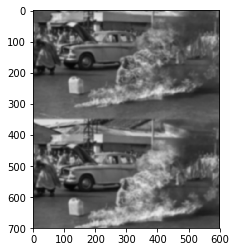

In [26]:
plt.imshow(cv2.imread('F:/react-data/iconic/image-analysis/test_results/Monk/preproc_2/' + d['fn'][168]))

In [21]:
d['fn'][42]

'9220.jpg'

In [ ]:
        
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)
    cropped_image.show()